<a href="https://colab.research.google.com/github/nipunikajain/DeepLearning1/blob/main/Softmax_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Softmax Regression

Impementation of *classic* softmax regression (multinomial logistic regression)

### Imports

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn import datasets
import numpy as np

In [24]:
df = pd.read_csv('./Iris.csv', index_col=None, header=None)

df.drop([0],axis=1,inplace=True)

df.columns= ['x1', 'x2', 'x3', 'x4', 'y']

d = {'Iris-versicolor': 1,
     'Iris-virginica': 2,
     'Iris-setosa': 0,
}

df['y'] = df['y'].map(d)

df = df[1:]



,x1,x2,x3,x4,y
1,5.1,3.5,1.4,0.2,0.0
2,4.9,3.0,1.4,0.2,0.0
3,4.7,3.2,1.3,0.2,0.0
4,4.6,3.1,1.5,0.2,0.0
5,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
146,6.7,3.0,5.2,2.3,2.0
147,6.3,2.5,5.0,1.9,2.0
148,6.5,3.0,5.2,2.0,2.0
149,6.2,3.4,5.4,2.3,2.0


### Preparing Dataset

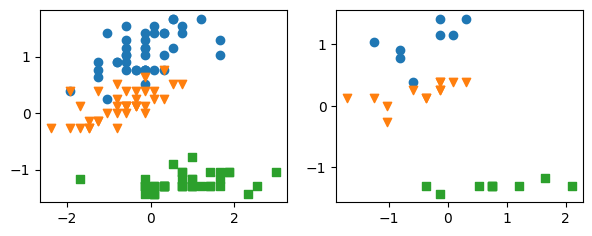

In [26]:
df = pd.read_csv('./Iris.csv', index_col=None, header=None)

df = df[1:]
df.drop([0],axis=1,inplace=True)


df.columns= ['x1', 'x2', 'x3', 'x4', 'y']

d = {'Iris-versicolor': 1,
     'Iris-virginica': 2,
     'Iris-setosa': 0,
}

df['y'] = df['y'].map(d)

# Assign features and target

s_array = df[['x2', 'x4']].to_numpy('float16')


X = torch.tensor(s_array, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

# Shuffling & train/test split

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent80 = int(shuffle_idx.size(0)*0.8)

X_train, X_test = X[shuffle_idx[:percent80]], X[shuffle_idx[percent80:]]
y_train, y_test = y[shuffle_idx[:percent80]], y[shuffle_idx[percent80:]]


# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma


fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1])
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], marker='v')
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], marker='s')
ax[1].scatter(X_test[y_test == 2, 0], X_test[y_test == 2, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], marker='v')
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], marker='s')
plt.show()


### Low-level implementation with manual gradients


In [27]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [28]:
def to_onehot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    y_cpu = y.to(torch.device('cpu'))
    y_onehot.scatter_(1, y_cpu.view(-1, 1).long(), 1).float()
    return y_onehot.to(DEVICE)

def softmax(z):
    return (torch.exp(z.t()) / torch.sum(torch.exp(z), dim=1)).t()
                    
def cross_entropy(softmax, y_target):
    return -torch.sum(torch.log(softmax) * (y_target), dim=1)

In [39]:
class SoftmaxRegression1():
  def __init__(self, num_features, num_classes):
    self.num_feature =num_features
    self.num_classes = num_classes
    self.weights = torch.zeros(num_classes, num_features, # h x m
                                   dtype=torch.float32, device=DEVICE)
    self.bias= torch.zeros(num_classes,dtype=torch.float32, device=DEVICE)

  def forward(self,x):
    logits = torch.mm(x, self.weights.t()) + self.bias # net inputs
    probas = softmax(logits) # activations
    return logits, probas

  def backward(self, x, y, probas):  
        grad_loss_wrt_w = -torch.mm(x.t(), y - probas).t()
        grad_loss_wrt_b = -torch.sum(y - probas)
        return grad_loss_wrt_w, grad_loss_wrt_b

  def predict_labels(self, x):
      logits, probas = self.forward(x)
      labels = torch.argmax(probas, dim=1)
      return labels    

  def evaluate(self, x, y):
      labels = self.predict_labels(x).float()
      accuracy = torch.sum(labels.view(-1) == y.float()).item() / y.size(0)
      return accuracy
  
  def train(self, x, y, num_epochs, learning_rate=0.01):
      epoch_cost = []
      for e in range(num_epochs):
          
          y_onehot = to_onehot(y, num_classes=self.num_classes)
          
          #### Compute outputs ####
          logits, probas = self.forward(x)
          
          #### Compute gradients ####
          grad_w, grad_b = self.backward(x, y_onehot, probas)

          #### Update weights ####
          self.weights -= learning_rate * grad_w / y.size(0)
          self.bias -= learning_rate * grad_b / y.size(0)
          
          #### Logging ####
          logits, probas = self.forward(x)
          cost = torch.mean(cross_entropy(probas, y_onehot))
          print('Epoch: %03d' % (e+1), end="")
          print(' | Train ACC: %.3f' % self.evaluate(x, y), end="")
          print(' | Cost: %.3f' % cost)
          epoch_cost.append(cost)
      return epoch_cost

In [40]:
X_train = X_train.to(DEVICE)
y_train = y_train.to(DEVICE)

model1 = SoftmaxRegression1(num_features=2, num_classes=3)
epoch_cost = model1.train(X_train, y_train, 
                          num_epochs=50,
                          learning_rate=0.1)

print('\nModel parameters:')
print('  Weights: %s' % model1.weights)
print('  Bias: %s' % model1.bias)

Epoch: 001 | Train ACC: 0.867 | Cost: 1.055
Epoch: 002 | Train ACC: 0.867 | Cost: 1.016
Epoch: 003 | Train ACC: 0.867 | Cost: 0.979
Epoch: 004 | Train ACC: 0.858 | Cost: 0.945
Epoch: 005 | Train ACC: 0.858 | Cost: 0.914
Epoch: 006 | Train ACC: 0.858 | Cost: 0.886
Epoch: 007 | Train ACC: 0.858 | Cost: 0.859
Epoch: 008 | Train ACC: 0.858 | Cost: 0.835
Epoch: 009 | Train ACC: 0.858 | Cost: 0.812
Epoch: 010 | Train ACC: 0.858 | Cost: 0.791
Epoch: 011 | Train ACC: 0.858 | Cost: 0.772
Epoch: 012 | Train ACC: 0.858 | Cost: 0.754
Epoch: 013 | Train ACC: 0.858 | Cost: 0.737
Epoch: 014 | Train ACC: 0.858 | Cost: 0.722
Epoch: 015 | Train ACC: 0.858 | Cost: 0.707
Epoch: 016 | Train ACC: 0.858 | Cost: 0.693
Epoch: 017 | Train ACC: 0.858 | Cost: 0.680
Epoch: 018 | Train ACC: 0.858 | Cost: 0.668
Epoch: 019 | Train ACC: 0.858 | Cost: 0.657
Epoch: 020 | Train ACC: 0.858 | Cost: 0.646
Epoch: 021 | Train ACC: 0.858 | Cost: 0.636
Epoch: 022 | Train ACC: 0.858 | Cost: 0.627
Epoch: 023 | Train ACC: 0.858 | 

### Evaluating the Model


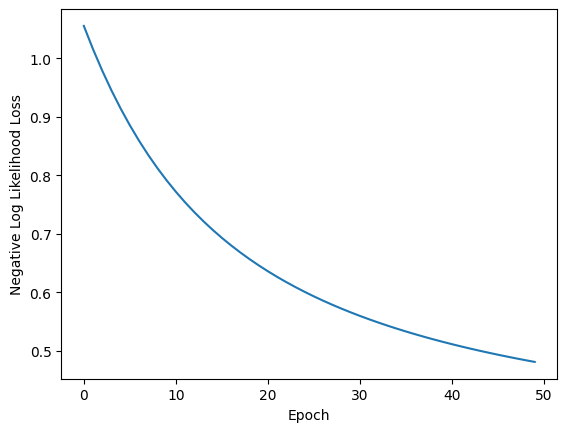

In [41]:
plt.plot(epoch_cost)
plt.ylabel('Negative Log Likelihood Loss')
plt.xlabel('Epoch')
plt.show()

In [42]:
X_test = X_test.to(DEVICE)
y_test = y_test.to(DEVICE)

test_acc = model1.evaluate(X_test, y_test)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 80.00%


In [43]:
from matplotlib.colors import ListedColormap
import numpy as np


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    logits, probas = classifier.forward(tensor)
    Z = np.argmax(probas.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

<ipython-input-43-0f2f17e653cc>:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


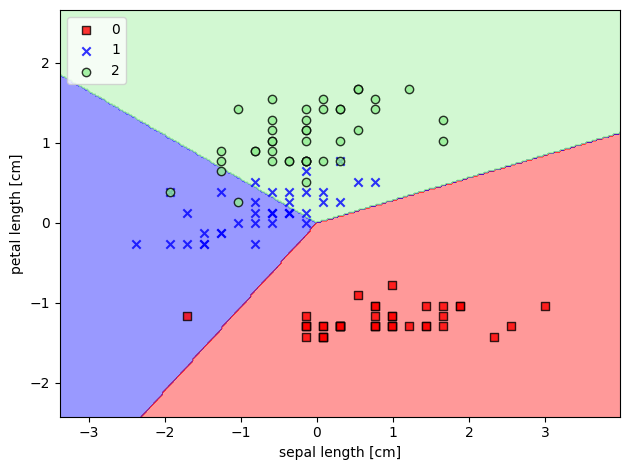

In [44]:
plot_decision_regions(X_train, y_train, classifier=model1)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### High-level implementation using the nn.Module API


In [46]:
class SoftmaxRegression2(torch.nn.Module):
  def __init__(self, num_features, num_classes):
    super(SoftmaxRegression2, self).__init__()
    self.linear = torch.nn.Linear(num_features, num_classes)
          # initialize weights to zeros here,
          # since we used zero weights in the
          # manual approach
    self.linear.weight.detach().zero_()
    self.linear.bias.detach().zero_()
    # Note: the trailing underscore
    # means "in-place operation" in the context
    # of PyTorch

  def forward(self, x):
    logits = self.linear(x)
    probas = F.softmax(logits, dim=1)
    return logits, probas

model2 = SoftmaxRegression2(num_features=2, num_classes=3).to(DEVICE)
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)


In [47]:
def comp_accuracy(true_labels, pred_labels):
    accuracy = torch.sum(true_labels.view(-1).float() == 
                         pred_labels.float()).item() / true_labels.size(0)
    return accuracy



X_train = X_train.to(DEVICE)
y_train = y_train.to(DEVICE)
X_test = X_test.to(DEVICE)
y_test = y_test.to(DEVICE)

num_epochs = 50
for epoch in range(num_epochs):
    
    #### Compute outputs ####
    logits, probas = model2(X_train)
    
    #### Compute gradients ####
    cost = F.cross_entropy(logits, y_train.long())
    optimizer.zero_grad()
    cost.backward()
    
    #### Update weights ####  
    optimizer.step()
    
    #### Logging ####      
    logits, probas = model2(X_train)
    acc = comp_accuracy(y_train, torch.argmax(probas, dim=1))
    print('Epoch: %03d' % (epoch + 1), end="")
    print(' | Train ACC: %.3f' % acc, end="")
    print(' | Cost: %.3f' % F.cross_entropy(logits, y_train.long()))


    
print('\nModel parameters:')
print('  Weights: %s' % model2.linear.weight)
print('  Bias: %s' % model2.linear.bias)

Epoch: 001 | Train ACC: 0.833 | Cost: 1.055
Epoch: 002 | Train ACC: 0.833 | Cost: 1.015
Epoch: 003 | Train ACC: 0.833 | Cost: 0.979
Epoch: 004 | Train ACC: 0.833 | Cost: 0.945
Epoch: 005 | Train ACC: 0.833 | Cost: 0.914
Epoch: 006 | Train ACC: 0.833 | Cost: 0.885
Epoch: 007 | Train ACC: 0.833 | Cost: 0.859
Epoch: 008 | Train ACC: 0.833 | Cost: 0.835
Epoch: 009 | Train ACC: 0.833 | Cost: 0.812
Epoch: 010 | Train ACC: 0.833 | Cost: 0.791
Epoch: 011 | Train ACC: 0.833 | Cost: 0.772
Epoch: 012 | Train ACC: 0.833 | Cost: 0.754
Epoch: 013 | Train ACC: 0.833 | Cost: 0.737
Epoch: 014 | Train ACC: 0.833 | Cost: 0.722
Epoch: 015 | Train ACC: 0.833 | Cost: 0.707
Epoch: 016 | Train ACC: 0.833 | Cost: 0.693
Epoch: 017 | Train ACC: 0.833 | Cost: 0.680
Epoch: 018 | Train ACC: 0.833 | Cost: 0.668
Epoch: 019 | Train ACC: 0.833 | Cost: 0.657
Epoch: 020 | Train ACC: 0.833 | Cost: 0.646
Epoch: 021 | Train ACC: 0.842 | Cost: 0.636
Epoch: 022 | Train ACC: 0.842 | Cost: 0.627
Epoch: 023 | Train ACC: 0.867 | 

In [48]:
X_test = X_test.to(DEVICE)
y_test = y_test.to(DEVICE)

test_acc = model1.evaluate(X_test, y_test)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 80.00%


<ipython-input-43-0f2f17e653cc>:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


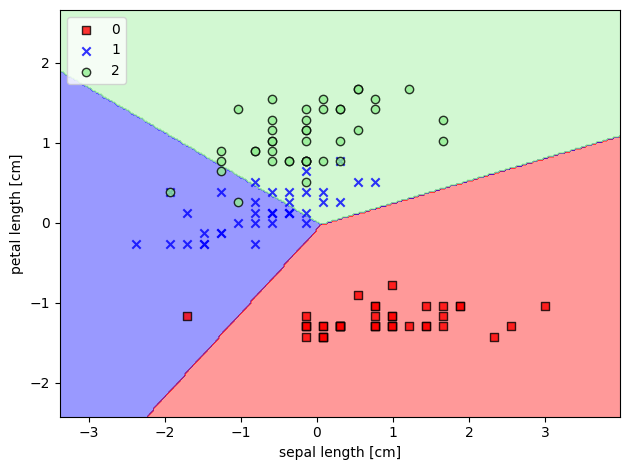

In [49]:
plot_decision_regions(X_train, y_train, classifier=model2)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
